# Multivariate Model

### Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import gc
import warnings
from collections import defaultdict
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, Flatten, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

warnings.filterwarnings("ignore")

### Configuration

In [2]:
TARGET_VARIABLES = ['co2', 'gdp', 'primary_energy_consumption']
N_TIME_STEPS = 5 # t, t-1 , t-2, t-3, t-4
N_STEPS_OUT = 1
VAL_SIZE = 0.15
TEST_SIZE = 0.15

G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

FEATURES = {
    'fossil_fuel_consumption', 'energy_per_capita',
    'electricity_generation', 'population',
    'nuclear_consumption', 'renewables_consumption'
}

### Utility Functions

In [3]:
def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()

In [4]:
def rmse(y_pred, y_actual):
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [5]:
def mase(y_actual, y_pred, period=1):

    mae_forecast = mean_absolute_error(y_actual, y_pred)
    
    # MAE of naive forecast
    naive_forecast = y_actual[:-period] if period > 0 else y_actual[:-1]
    actual_for_naive = y_actual[period:] if period > 0 else y_actual[1:]
    
    if len(naive_forecast) == 0:
        return np.nan
    
    mae_naive = mean_absolute_error(actual_for_naive, naive_forecast)
    
    if mae_naive == 0:
        return 0 if mae_forecast == 0 else np.inf
    
    return mae_forecast / mae_naive

### Data Prep

In [6]:
def load_data(save_dir='data_export'):
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')
    
    try:
        lag_df = pd.read_pickle(lag_path)
        print(f"Data shape: {lag_df.shape}")
        return lag_df
    
    except FileNotFoundError as e:
        print(f"Error in loading {e}")
        return None

In [7]:
def prepare_data(country_data, features, target, selected_lags):
    
    feature_cols = []
    feature_names = []
    
    for feature in features:
        if feature not in country_data.columns:
            continue
            
        for lag in selected_lags:
            if lag == 0:
                col = feature
            else:
                col = f"{feature}_lag{lag}"
            
            if col in country_data.columns:
                feature_cols.append(col)
                feature_names.append(f"{feature}_t{-lag if lag > 0 else ''}")
    
    # Removing duplicates
    feature_cols = list(dict.fromkeys(feature_cols))
    
    # Prepare data
    all_cols = feature_cols + [target, 'year']
    data_subset = country_data[all_cols].dropna()
    
    X = data_subset[feature_cols].values
    y = data_subset[target].values
    years = data_subset['year'].values
    
    # Adjusting for multi-step forecasting
    if len(y) <= N_STEPS_OUT:
        return None, None, None, None, None, None, None, None
    
    # Split data
    total_len = len(y) - N_STEPS_OUT + 1
    n_test = int(total_len * TEST_SIZE)
    n_val = int(total_len * VAL_SIZE)
    n_train = total_len - n_test - n_val
    
    # Create sequences for multi-step
    X_train = X[:n_train]
    """y_train = []
    for i in range(n_train):
        y_train.append(y[i:i+N_STEPS_OUT])
    y_train = np.array(y_train)"""
    y_train = np.array([y[i:i+N_STEPS_OUT] for i in range(n_train)])
     
    X_val = X[n_train:n_train + n_val]
    """y_val = []
    for i in range(n_val):
        y_val.append(y[n_train+i:n_train+i+N_STEPS_OUT])
    y_val = np.array(y_val)"""
    y_val = np.array([y[n_train+i:n_train+i+N_STEPS_OUT] for i in range(n_val)])
    
    X_test = X[n_train + n_val:n_train + n_val + n_test]
    """y_test = []
    for i in range(n_test):
        y_test.append(y[n_train+n_val+i:n_train+n_val+i+N_STEPS_OUT])
    y_test = np.array(y_test)"""
    y_test = np.array([y[n_train+n_val+i:n_train+n_val+i+N_STEPS_OUT] for i in range(n_test)])

    test_years = years[n_train + n_val:n_train + n_val + n_test]
    
    print(f"\nData shapes - Train:{len(y_train)}, Val:{len(y_val)}, Test:{len(y_test)}")
    print(f"Features: {len(feature_cols)}, Targets: {len(target)}, Forecasting Steps: {N_STEPS_OUT}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test, test_years, feature_names


In [8]:
def build_lstm(input_shape, output_shape, hidden=32):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(output_shape)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [9]:
def build_bilstm(input_shape, output_shape, hidden=16):
    model = Sequential([
        Bidirectional(LSTM(hidden, activation='relu', kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.01)),
                      input_shape=input_shape),
        Dense(output_shape)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [10]:
def build_edlstm(input_shape, output_shape, hidden=16):
    model = Sequential([
        LSTM(hidden, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        RepeatVector(output_shape),
        LSTM(hidden, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)),
        TimeDistributed(Dense(1)),
        Flatten() # (batch, N_STEPS_OUT)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

In [11]:
def build_cnn(input_shape, output_shape, filters=32, hidden=16):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=l2(0.01)),
        Flatten(),
        Dense(hidden, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(output_shape)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

### Train

In [12]:
def train_dl_model(model_func, X_train, y_train, X_val, y_val, X_test, y_test, model_name, target):

    try:
        # Scale data
        X_scaler = StandardScaler()
        y_scaler = StandardScaler()
        
        X_train_scaled = X_scaler.fit_transform(X_train)
        X_val_scaled = X_scaler.transform(X_val)
        X_test_scaled = X_scaler.transform(X_test)
        
        # Maintaining 2D structure for single target
        y_train_scaled = y_scaler.fit_transform(y_train)
        y_val_scaled = y_scaler.transform(y_val)
        
        # Reshape X: (n_samples, n_time_steps, n_features)
        X_train_dl = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
        X_val_dl = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])
        X_test_dl = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
        
        # Build model
        input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])
        output_shape = N_STEPS_OUT
        model = model_func(input_shape, output_shape)
        
        # Train
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, 
                                     restore_best_weights=True)
        
        model.fit(
            X_train_dl, y_train_scaled, validation_data=(X_val_dl, y_val_scaled),
            epochs=50,
            batch_size=min(32, len(X_train_dl)),
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Predict
        preds_scaled = model.predict(X_test_dl, verbose=0)
        
        # Inverse transform
        preds = y_scaler.inverse_transform(preds_scaled)
        
        # Calculate metrics
        rmse_scores = []
        mase_scores = []
        for h in range(N_STEPS_OUT):
            rmse_score = rmse(preds[:, h], y_test[:, h])
            mase_score = mase(y_test[:, h], preds[:, h])
            rmse_scores.append(rmse_score)
            mase_scores.append(mase_score)
            
        # Average metrics
        avg_rmse = np.mean(rmse_scores)
        avg_mase = np.mean(mase_scores)
        
        metrics = {
            'rmse': np.mean(rmse_scores),
            'mase': np.mean(mase_scores),
            'rmse_for_each': rmse_scores,
            'mase_for_each': mase_scores
        }
        
        print(f"    {model_name} - Avg RMSE: {avg_rmse:.4f}, Avg MASE: {avg_mase:.4f}")
        
        del model
        clear_memory()
        
        return preds, y_test, avg_rmse, avg_mase, metrics
        
    except Exception as e:
        print(f"{model_name} failed: {e}")
        clear_memory()
        return None, None, None, None, None

### Test

In [13]:
def test_dl_models(selected_features, selected_lags, lag_df):
    
    results = defaultdict(list)
    detailed_results = {}
    
    for target in TARGET_VARIABLES:
        print(f"\nTesting models for {target}")

        for country in tqdm(G20_COUNTRIES, desc=f"Testing {target}"):

            print(f"for {country}")
            country_data = lag_df[lag_df['country'] == country].sort_values('year')
            data_prep = prepare_data(country_data, selected_features, target, selected_lags)
            X_train, y_train, X_val, y_val, X_test, y_test, test_years, feature_names = data_prep

            # DL models
            models = [
                ('LSTM', build_lstm),
                ('Bi-LSTM', build_bilstm),
                ('ED-LSTM', build_edlstm),
                ('CNN', build_cnn)
            ]
            
            for model_name, model_func in models:
                print(f"    Training {model_name}")
                model_result = train_dl_model(model_func, X_train, y_train, X_val, y_val,
                                              X_test, y_test, model_name, target)
                
                if model_result[0] is not None:
                    preds, actual, avg_rmse, avg_mase, metrics = model_result
                    results[(target, model_name)].append({
                        'country': country,
                        'avg_rmse': avg_rmse,
                        'avg_mase': avg_mase,
                        'metrics': metrics
                    })
                    detailed_results[(country, target, model_name)] = {
                        'predictions': preds,
                        'actuals': actual,
                        'years': test_years,
                        'metrics': metrics,
                        'features': selected_features
                    }

    return results, detailed_results

In [14]:
def summarise_results(results, save_dir='data_export'):

    target_summary = {}
    summary = []

    for target in TARGET_VARIABLES:
        print(f"\nfor {target}")
        target_summary[target] = {}

        model_names = set()
        for (tgt, mdl), _ in results.items():
            if tgt == target:
                model_names.add(mdl)

        for model_name in model_names:
            key = (target, model_name)
            if key in results and results[key]:
                model_results = results[key]

                rmse_values = []
                mase_values = []
                countries = []
                for r in model_results:
                    rmse_values.append(r['avg_rmse'])
                    mase_values.append(r['avg_mase'])
                    countries.append(r['country'])

                # Stats
                summary_stats = {
                    'n_countries': len(model_results),
                    'avg_rmse': np.mean(rmse_values),
                    'std_rmse': np.std(rmse_values),
                    'min_rmse': np.min(rmse_values),
                    'max_rmse': np.max(rmse_values),
                    'avg_mase': np.mean(mase_values),
                    'std_mase': np.std(mase_values)
                }

                target_summary [target][model_name] = summary_stats

                summary.append({
                    'target': target,
                    'model': model_name,
                    'n_countries': summary_stats['n_countries'],
                    'avg_rmse': summary_stats['avg_rmse'],
                    'std_rmse': summary_stats['std_rmse'],
                    'min_rmse': summary_stats['min_rmse'],
                    'max_rmse': summary_stats['max_rmse'],
                    'avg_mase': summary_stats['avg_mase'],
                    'std_mase': summary_stats['std_mase']
                })

                print(f"  {model_name}:")
                print(f"    Countries: {summary_stats['n_countries']}")
                print(f"    Avg RMSE: {summary_stats['avg_rmse']:.4f}, Std {summary_stats['std_rmse']:.4f}")
                print(f"    Avg MASE: {summary_stats['avg_mase']:.4f}, Std {summary_stats['std_mase']:.4f}")
    
    # All model
    all_models = set()
    for (_, model), _ in results.items():
        all_models.add(model)
    
    for model_name in all_models:
        rmse_over_targets = []
        mase_over_targets = []
        
        for target in TARGET_VARIABLES:
            if target in target_summary and model_name in target_summary[target]:
                rmse_over_targets.append(target_summary[target][model_name]['avg_rmse'])
                mase_over_targets.append(target_summary[target][model_name]['avg_mase'])
    
    # Save results
    results_dir = os.path.join(save_dir, '03_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save summary CSV
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(os.path.join(results_dir, 'multivariate_summary.csv'), index=False)
    
    # Save detailed results
    with open(os.path.join(results_dir, 'multivariate_results.pkl'), 'wb') as f:
        save_data = {
            'results': dict(results),
            'target_summaries': target_summary
        }
        pickle.dump(save_data, f)
    
    return target_summary
    

In [15]:
def plot_multi_models(country, target, save_dir='data_export'):
    
    pred_path = os.path.join(save_dir, '03_results', 'multivariate_detailed.pkl')
    try:
        with open(pred_path, 'rb') as f:
            pred_data = pickle.load(f)
        print(f"Loaded predictions for {target}")
    except FileNotFoundError:
        print(f"Prediction file not found: {pred_path}")
        return
    
    # Load lag data
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')
    lag_df = pd.read_pickle(lag_path)
    
    # Get country data
    country_data = lag_df[lag_df['country'] == country].sort_values('year')
    full_years = country_data['year'].values
    full_actual = country_data[target].values

    # Calculate split points
    total_len = len(full_actual)
    n_test = int(total_len * TEST_SIZE)
    n_val = int(total_len * VAL_SIZE)
    n_train = total_len - n_test - n_val
    
    # Split data for visualization
    train_val_years = full_years[:n_train + n_val]
    train_val_actual = full_actual[:n_train + n_val]
    test_years_hist = full_years[n_train + n_val:]
    test_actual_hist = full_actual[n_train + n_val:]
    
    # Check available models
    models = ['LSTM', 'Bi-LSTM', 'ED-LSTM', 'CNN']
    available_models = []
    
    for model in models:
        key = (country, target, model)
        if key in pred_data:
            available_models.append(model)
    
    if not available_models:
        print(f"No prediction data for {country} - {target}")
        return
    
    # Subplot layout
    n_models = len(available_models)
    cols = min(2, n_models)
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    
    # Handle single subplot
    if n_models == 1:
        axes = [axes]
    elif rows == 1 and n_models > 1:
        axes = list(axes)
    elif rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot each model
    for i, model in enumerate(available_models):
        ax = axes[i]
        key = (country, target, model)
        data = pred_data[key]
        
        test_start_years = data['years']
        preds = data['predictions']  # (n_test, n_steps_out)
        actual_test = data['actuals']
        
        # Plot train/validation historical data
        ax.plot(train_val_years, train_val_actual, 'b-', label='Historical', linewidth=2, alpha=0.7)
        
        # Plot test historical data
        ax.plot(test_years_hist, test_actual_hist, 'g-', label='Test Historical', linewidth=2, alpha=0.7)
        
        if N_STEPS_OUT == 1:
            # Flatten predictions for single step
            pred_values = preds.flatten()
            ax.plot(test_start_years, pred_values, 'r--', label='Predicted', 
                    linewidth=2, marker='o', markersize=3)
            
            # Actual values
            actual_values = actual_test.flatten()
            
            # Calculate metrics
            if len(pred_values) > 0 and len(actual_values) > 0:
                rmse_val = rmse(pred_values, actual_values)
                mase_val = mase(actual_values, pred_values)
            else:
                rmse_val = np.inf
                mase_val = np.inf
        else:
            # Multi-step plotting 
            for j in range(len(test_start_years)):
                pred_years = []
                pred_values = []
                
                for k in range(N_STEPS_OUT):
                    year = test_start_years[j] + k
                    value = preds[j, k]
                    pred_years.append(year)
                    pred_values.append(value)
                
                ax.plot(pred_years, pred_values, 'r--', alpha=0.5, linewidth=1)
            
            ax.plot([], [], 'r--', label='Predicted', linewidth=2)
            
            # Metrics for first step
            first_step_preds = preds[:, 0]
            first_step_actuals = actual_test[:, 0]
            rmse_val = rmse(first_step_preds, first_step_actuals)
            mase_val = mase(first_step_actuals, first_step_preds)
        
        # Title with metrics
        ax.set_title(f'{model}\nRMSE: {rmse_val:.2f}, MASE: {mase_val:.2f}', fontsize=10)
        
        ax.legend(fontsize=8, loc='upper left')
        ax.set_xlabel('Year', fontsize=9)
        ax.set_ylabel(target, fontsize=9)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.set_xlim(full_years[0], full_years[-1])
    
    # Get feature info
    first_key = (country, target, available_models[0])
    features_used = pred_data[first_key].get('features', 'Unknown')
    plt.suptitle(f'{country}: {target}\nFeatures: {str(features_used)}', 
                 fontsize=14)
    plt.tight_layout()
    
    # Save plot
    plots_dir = os.path.join(save_dir, '03_plots', 'multivariate_models')
    os.makedirs(plots_dir, exist_ok=True)
    
    filename = f'multi_{country}_{target}_all_models.png'
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

In [16]:
lag_df = load_data()

selected_lags = [0, 1, 2, 3, 4]

results, detailed_results = test_dl_models(FEATURES, selected_lags, lag_df)

Data shape: (1138, 992)

Testing models for co2


Testing co2:   0%|          | 0/19 [00:00<?, ?it/s]

for United States

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 115.5321, Avg MASE: 0.3377

    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 338.3780, Avg MASE: 1.2208
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 165.0882, Avg MASE: 0.3762
    Training CNN
    CNN - Avg RMSE: 285.1719, Avg MASE: 0.8846


Testing co2:   5%|▌         | 1/19 [00:19<05:58, 19.90s/it]

for China

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 9405.0570, Avg MASE: 26.4003
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 2834.6348, Avg MASE: 7.4796
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 5824.6745, Avg MASE: 16.1728
    Training CNN
    CNN - Avg RMSE: 1157.1735, Avg MASE: 3.3151


Testing co2:  11%|█         | 2/19 [00:32<04:27, 15.75s/it]

for Japan

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 186.4358, Avg MASE: 4.5864
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 210.8501, Avg MASE: 5.2197
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 206.6362, Avg MASE: 5.0952
    Training CNN
    CNN - Avg RMSE: 252.4319, Avg MASE: 6.2636


Testing co2:  16%|█▌        | 3/19 [00:45<03:53, 14.61s/it]

for Germany

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 49.5936, Avg MASE: 1.0144
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 34.7485, Avg MASE: 0.6936
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 55.3365, Avg MASE: 1.1602
    Training CNN
    CNN - Avg RMSE: 69.7805, Avg MASE: 1.5251


Testing co2:  21%|██        | 4/19 [01:03<03:59, 15.95s/it]

for United Kingdom

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 21.3912, Avg MASE: 0.7971
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 18.4035, Avg MASE: 0.5336
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 22.5495, Avg MASE: 0.7907
    Training CNN
    CNN - Avg RMSE: 33.5772, Avg MASE: 1.2136


Testing co2:  26%|██▋       | 5/19 [01:20<03:47, 16.23s/it]

for France

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 17.2047, Avg MASE: 0.5895
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 32.9515, Avg MASE: 1.2715
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 14.7959, Avg MASE: 0.5724
    Training CNN
    CNN - Avg RMSE: 27.1513, Avg MASE: 0.9408


Testing co2:  32%|███▏      | 6/19 [01:43<04:00, 18.48s/it]

for Italy

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 17.1795, Avg MASE: 0.5707
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 24.3013, Avg MASE: 0.7247
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 22.4054, Avg MASE: 0.7011
    Training CNN
    CNN - Avg RMSE: 23.8617, Avg MASE: 0.7493


Testing co2:  37%|███▋      | 7/19 [02:07<04:01, 20.12s/it]

for Canada

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 11.9223, Avg MASE: 0.4931
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 25.8946, Avg MASE: 1.1583
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 14.6749, Avg MASE: 0.5600
    Training CNN
    CNN - Avg RMSE: 14.8917, Avg MASE: 0.6506


Testing co2:  42%|████▏     | 8/19 [02:31<03:57, 21.56s/it]

for Brazil

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 67.4650, Avg MASE: 2.7032
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 57.7319, Avg MASE: 2.2677
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 45.2692, Avg MASE: 1.7213
    Training CNN
    CNN - Avg RMSE: 63.6438, Avg MASE: 2.5193


Testing co2:  47%|████▋     | 9/19 [02:54<03:39, 21.98s/it]

for Russia

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 91.6688, Avg MASE: 1.2115
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 161.8267, Avg MASE: 2.4525
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 109.2134, Avg MASE: 1.3888
    Training CNN
    CNN - Avg RMSE: 55.5890, Avg MASE: 0.8330


Testing co2:  53%|█████▎    | 10/19 [03:21<03:32, 23.57s/it]

for India

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 512.0526, Avg MASE: 2.3858
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 266.4796, Avg MASE: 1.0757
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 560.1016, Avg MASE: 2.6082
    Training CNN
    CNN - Avg RMSE: 261.6032, Avg MASE: 1.1715


Testing co2:  58%|█████▊    | 11/19 [03:46<03:10, 23.87s/it]

for Australia

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 38.2921, Avg MASE: 4.0091
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 51.0786, Avg MASE: 5.2703
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 36.3237, Avg MASE: 3.9446
    Training CNN
    CNN - Avg RMSE: 24.8995, Avg MASE: 2.6293


Testing co2:  63%|██████▎   | 12/19 [04:12<02:52, 24.66s/it]

for Mexico

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 39.5766, Avg MASE: 1.5126
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 46.7859, Avg MASE: 1.9399
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 53.8533, Avg MASE: 2.2261
    Training CNN
    CNN - Avg RMSE: 22.5408, Avg MASE: 0.8268


Testing co2:  68%|██████▊   | 13/19 [04:35<02:23, 23.93s/it]

for Indonesia

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 211.0271, Avg MASE: 4.0971
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 131.8218, Avg MASE: 2.6985
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 235.2363, Avg MASE: 4.7738
    Training CNN
    CNN - Avg RMSE: 212.2428, Avg MASE: 4.3446


Testing co2:  74%|███████▎  | 14/19 [04:58<01:58, 23.66s/it]

for Turkey

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 30.3528, Avg MASE: 1.5351
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 20.7188, Avg MASE: 0.9803
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 62.7478, Avg MASE: 3.4856
    Training CNN
    CNN - Avg RMSE: 53.6781, Avg MASE: 2.9045


Testing co2:  79%|███████▉  | 15/19 [05:25<01:39, 24.75s/it]

for Saudi Arabia

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 1726.7163, Avg MASE: 32.4203
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 1062.5215, Avg MASE: 18.1263
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 314.1213, Avg MASE: 7.6297
    Training CNN
    CNN - Avg RMSE: 1220.9130, Avg MASE: 20.1838


Testing co2:  84%|████████▍ | 16/19 [05:49<01:13, 24.63s/it]

for South Africa

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 117.3625, Avg MASE: 7.2998
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 33.5258, Avg MASE: 1.9151
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 19.0139, Avg MASE: 1.0776
    Training CNN
    CNN - Avg RMSE: 206.7630, Avg MASE: 12.6754


Testing co2:  89%|████████▉ | 17/19 [06:10<00:46, 23.34s/it]

for Argentina

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 13.5383, Avg MASE: 0.6890
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 27.1344, Avg MASE: 1.6950
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 19.5381, Avg MASE: 1.1627
    Training CNN
    CNN - Avg RMSE: 23.8186, Avg MASE: 1.5261


Testing co2:  95%|█████████▍| 18/19 [06:35<00:23, 23.86s/it]

for South Korea

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 575.2394, Avg MASE: 19.3785
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 315.2374, Avg MASE: 11.2477
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 185.4512, Avg MASE: 6.7737
    Training CNN
    CNN - Avg RMSE: 279.7166, Avg MASE: 9.7223


Testing co2: 100%|██████████| 19/19 [07:00<00:00, 22.13s/it]



Testing models for gdp


Testing gdp:   0%|          | 0/19 [00:00<?, ?it/s]

for United States

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 443994321441.8969, Avg MASE: 0.5570
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 722145663440.7723, Avg MASE: 1.0925
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 917907266866.1498, Avg MASE: 1.3338
    Training CNN
    CNN - Avg RMSE: 278806013137.8698, Avg MASE: 0.3382


Testing gdp:   5%|▌         | 1/19 [00:27<08:23, 27.98s/it]

for China

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 3524751488464.3301, Avg MASE: 2.7048
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 4482119599613.8672, Avg MASE: 3.3843
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 1874964233831.8320, Avg MASE: 1.5891
    Training CNN
    CNN - Avg RMSE: 1018903278529.2854, Avg MASE: 0.6892


Testing gdp:  11%|█         | 2/19 [00:57<08:09, 28.77s/it]

for Japan

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 755561888209.1160, Avg MASE: 7.5999
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 284950410047.1614, Avg MASE: 2.8492
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 499204160093.8555, Avg MASE: 4.7770
    Training CNN
    CNN - Avg RMSE: 255834615382.8890, Avg MASE: 2.3102


Testing gdp:  16%|█▌        | 3/19 [01:24<07:30, 28.13s/it]

for Germany

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 360034643472.1044, Avg MASE: 3.6766
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 395659861081.1824, Avg MASE: 3.6417
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 455811158593.4778, Avg MASE: 4.8777
    Training CNN
    CNN - Avg RMSE: 169460139169.9097, Avg MASE: 1.5580


Testing gdp:  21%|██        | 4/19 [01:54<07:12, 28.80s/it]

for United Kingdom

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 384378651531.1122, Avg MASE: 2.2463
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 655255133634.1798, Avg MASE: 3.7965
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 556257939692.8948, Avg MASE: 3.2785
    Training CNN
    CNN - Avg RMSE: 342562001739.3292, Avg MASE: 1.9722


Testing gdp:  26%|██▋       | 5/19 [02:24<06:48, 29.19s/it]

for France

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 160583573248.1042, Avg MASE: 0.8895
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 171558329683.7484, Avg MASE: 1.1680
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 142948413989.0168, Avg MASE: 0.9903
    Training CNN
    CNN - Avg RMSE: 168298426102.9079, Avg MASE: 1.0788


Testing gdp:  32%|███▏      | 6/19 [02:53<06:20, 29.30s/it]

for Italy

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 134601189217.2494, Avg MASE: 1.1787
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 97170160736.2983, Avg MASE: 0.7761
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 116033102245.9677, Avg MASE: 1.0572
    Training CNN
    CNN - Avg RMSE: 150429954172.2519, Avg MASE: 1.3234


Testing gdp:  37%|███▋      | 7/19 [03:24<05:57, 29.82s/it]

for Canada

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 74004672012.3427, Avg MASE: 0.9740
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 44184154934.1701, Avg MASE: 0.4967
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 53855132300.0089, Avg MASE: 0.7500
    Training CNN
    CNN - Avg RMSE: 35178105615.9643, Avg MASE: 0.4626


Testing gdp:  42%|████▏     | 8/19 [03:55<05:32, 30.26s/it]

for Brazil

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 353814115789.1076, Avg MASE: 3.7662
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 167314057100.8820, Avg MASE: 1.7366
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 178761633301.3082, Avg MASE: 1.8129
    Training CNN
    CNN - Avg RMSE: 351479866302.9124, Avg MASE: 3.6654


Testing gdp:  47%|████▋     | 9/19 [04:24<04:55, 29.59s/it]

for Russia

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 361772469128.7033, Avg MASE: 2.9077
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 495540232435.0155, Avg MASE: 4.0326
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 205104326217.3041, Avg MASE: 1.6757
    Training CNN
    CNN - Avg RMSE: 989459361255.4572, Avg MASE: 7.9090


Testing gdp:  53%|█████▎    | 10/19 [04:54<04:28, 29.78s/it]

for India

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 731011069733.3091, Avg MASE: 0.9162
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 439982022303.7067, Avg MASE: 0.6431
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 595201856740.8649, Avg MASE: 0.7004
    Training CNN
    CNN - Avg RMSE: 716010592383.6373, Avg MASE: 0.8825


Testing gdp:  58%|█████▊    | 11/19 [05:26<04:03, 30.48s/it]

for Australia

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 181191838185.2928, Avg MASE: 3.9771
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 148669189333.9429, Avg MASE: 3.1253
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 391876163725.4552, Avg MASE: 8.3353
    Training CNN
    CNN - Avg RMSE: 100800503817.1344, Avg MASE: 2.2380


Testing gdp:  63%|██████▎   | 12/19 [05:55<03:30, 30.11s/it]

for Mexico

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 243426627520.6474, Avg MASE: 2.7563
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 109704332539.0937, Avg MASE: 0.9969
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 110560720803.3527, Avg MASE: 1.1852
    Training CNN
    CNN - Avg RMSE: 146468606313.3100, Avg MASE: 1.6128


Testing gdp:  68%|██████▊   | 13/19 [06:28<03:05, 30.85s/it]

for Indonesia

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 981206662353.3085, Avg MASE: 6.6682
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 1179798880916.8215, Avg MASE: 7.7129
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 611549233186.4996, Avg MASE: 4.1738
    Training CNN
    CNN - Avg RMSE: 1017313194154.2485, Avg MASE: 7.1405


Testing gdp:  74%|███████▎  | 14/19 [07:01<02:37, 31.53s/it]

for Turkey

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 81872158477.8263, Avg MASE: 0.7018
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 102382357223.9925, Avg MASE: 0.8704
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 184060412932.7714, Avg MASE: 1.6658
    Training CNN
    CNN - Avg RMSE: 95809974339.3622, Avg MASE: 0.7159


Testing gdp:  79%|███████▉  | 15/19 [07:34<02:08, 32.12s/it]

for Saudi Arabia

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 7706684072434.5723, Avg MASE: 72.7809
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 12666445661265.9551, Avg MASE: 110.2882
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 2124743520499.8657, Avg MASE: 23.5252
    Training CNN
    CNN - Avg RMSE: 11610111754223.9277, Avg MASE: 134.4449


Testing gdp:  84%|████████▍ | 16/19 [08:03<01:33, 31.02s/it]

for South Africa

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 225292555771.9424, Avg MASE: 9.2474
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 215886555913.3952, Avg MASE: 8.6176
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 296575167861.1048, Avg MASE: 12.1116
    Training CNN
    CNN - Avg RMSE: 72569036769.4566, Avg MASE: 2.5912


Testing gdp:  89%|████████▉ | 17/19 [08:36<01:03, 31.73s/it]

for Argentina

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 127967187958.9748, Avg MASE: 2.0984
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 95235738563.8746, Avg MASE: 1.3718
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 129655967318.1548, Avg MASE: 2.3460
    Training CNN
    CNN - Avg RMSE: 87264680874.9851, Avg MASE: 1.4749


Testing gdp:  95%|█████████▍| 18/19 [09:10<00:32, 32.48s/it]

for South Korea

Data shapes - Train:25, Val:4, Test:4
Features: 30, Targets: 3, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 38076430292.3160, Avg MASE: 0.6324
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 24536400482.2879, Avg MASE: 0.3162
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 28557346279.2554, Avg MASE: 0.5027
    Training CNN
    CNN - Avg RMSE: 32616978315.8484, Avg MASE: 0.5450


Testing gdp: 100%|██████████| 19/19 [09:46<00:00, 30.86s/it]



Testing models for primary_energy_consumption


Testing primary_energy_consumption:   0%|          | 0/19 [00:00<?, ?it/s]

for United States

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 616.3590, Avg MASE: 0.4911
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 1088.8222, Avg MASE: 0.9113
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 834.5414, Avg MASE: 0.7732
    Training CNN
    CNN - Avg RMSE: 475.9135, Avg MASE: 0.3816


Testing primary_energy_consumption:   5%|▌         | 1/19 [00:35<10:33, 35.20s/it]

for China

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 10930.3606, Avg MASE: 5.8774
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 28626.9849, Avg MASE: 15.4980
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 4476.9733, Avg MASE: 2.4566
    Training CNN
    CNN - Avg RMSE: 22282.9816, Avg MASE: 11.9657


Testing primary_energy_consumption:  11%|█         | 2/19 [01:06<09:24, 33.20s/it]

for Japan

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 78.1259, Avg MASE: 0.3321
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 67.9367, Avg MASE: 0.2802
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 101.1263, Avg MASE: 0.3481
    Training CNN
    CNN - Avg RMSE: 186.2980, Avg MASE: 0.7495


Testing primary_energy_consumption:  16%|█▌        | 3/19 [01:40<08:56, 33.52s/it]

for Germany

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 82.3601, Avg MASE: 0.3150
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 222.1653, Avg MASE: 1.0819
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 388.1489, Avg MASE: 1.8758
    Training CNN
    CNN - Avg RMSE: 249.9776, Avg MASE: 1.2401


Testing primary_energy_consumption:  21%|██        | 4/19 [02:15<08:30, 34.02s/it]

for United Kingdom

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 77.6919, Avg MASE: 0.7548
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 202.8082, Avg MASE: 2.0746
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 106.6558, Avg MASE: 1.0305
    Training CNN
    CNN - Avg RMSE: 70.3222, Avg MASE: 0.6600


Testing primary_energy_consumption:  26%|██▋       | 5/19 [02:51<08:04, 34.58s/it]

for France

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 78.9153, Avg MASE: 0.2796
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 235.6639, Avg MASE: 0.9988
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 115.2758, Avg MASE: 0.4240
    Training CNN
    CNN - Avg RMSE: 105.2237, Avg MASE: 0.4044


Testing primary_energy_consumption:  32%|███▏      | 6/19 [03:27<07:36, 35.10s/it]

for Italy

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 92.2835, Avg MASE: 0.7672
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 57.7408, Avg MASE: 0.4891
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 65.3460, Avg MASE: 0.5777
    Training CNN
    CNN - Avg RMSE: 58.8637, Avg MASE: 0.4892


Testing primary_energy_consumption:  37%|███▋      | 7/19 [04:02<06:59, 34.95s/it]

for Canada

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 183.6011, Avg MASE: 1.4333
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 139.1722, Avg MASE: 1.0092
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 130.4025, Avg MASE: 0.9835
    Training CNN
    CNN - Avg RMSE: 108.4580, Avg MASE: 0.7877


Testing primary_energy_consumption:  42%|████▏     | 8/19 [04:40<06:35, 35.94s/it]

for Brazil

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 174.7574, Avg MASE: 0.9538
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 257.8936, Avg MASE: 1.6440
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 111.4911, Avg MASE: 0.5973
    Training CNN
    CNN - Avg RMSE: 296.1328, Avg MASE: 1.9240


Testing primary_energy_consumption:  47%|████▋     | 9/19 [05:16<06:02, 36.25s/it]

for Russia

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 565.4707, Avg MASE: 2.1931
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 289.9566, Avg MASE: 1.0641
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 543.1330, Avg MASE: 2.1263
    Training CNN
    CNN - Avg RMSE: 230.0188, Avg MASE: 0.9372


Testing primary_energy_consumption:  53%|█████▎    | 10/19 [05:54<05:31, 36.79s/it]

for India

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 975.7476, Avg MASE: 1.4706
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 1337.4141, Avg MASE: 2.0202
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 568.0605, Avg MASE: 0.7106
    Training CNN
    CNN - Avg RMSE: 1135.9051, Avg MASE: 1.7417


Testing primary_energy_consumption:  58%|█████▊    | 11/19 [06:32<04:54, 36.86s/it]

for Australia

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 209.4512, Avg MASE: 4.3328
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 39.7895, Avg MASE: 0.8126
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 347.0066, Avg MASE: 7.0722
    Training CNN
    CNN - Avg RMSE: 183.8782, Avg MASE: 3.6894


Testing primary_energy_consumption:  63%|██████▎   | 12/19 [07:10<04:20, 37.24s/it]

for Mexico

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 121.0087, Avg MASE: 0.7825
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 178.4788, Avg MASE: 1.2275
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 250.0665, Avg MASE: 1.8774
    Training CNN
    CNN - Avg RMSE: 128.0408, Avg MASE: 0.8232


Testing primary_energy_consumption:  68%|██████▊   | 13/19 [07:49<03:48, 38.02s/it]

for Indonesia

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 384.6825, Avg MASE: 1.7502
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 169.4469, Avg MASE: 0.7598
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 310.1985, Avg MASE: 1.2117
    Training CNN
    CNN - Avg RMSE: 375.2960, Avg MASE: 1.7576


Testing primary_energy_consumption:  74%|███████▎  | 14/19 [08:29<03:11, 38.40s/it]

for Turkey

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 32.3211, Avg MASE: 0.5516
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 150.5317, Avg MASE: 2.5295
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 133.5371, Avg MASE: 2.4532
    Training CNN
    CNN - Avg RMSE: 160.4812, Avg MASE: 3.0289


Testing primary_energy_consumption:  79%|███████▉  | 15/19 [09:09<02:36, 39.11s/it]

for Saudi Arabia

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 13206.8214, Avg MASE: 115.3227
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 19780.0964, Avg MASE: 156.1821
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 1017.1179, Avg MASE: 7.5251
    Training CNN
    CNN - Avg RMSE: 3845.1952, Avg MASE: 34.3597


Testing primary_energy_consumption:  84%|████████▍ | 16/19 [09:45<01:54, 38.16s/it]

for South Africa

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 295.3069, Avg MASE: 6.9347
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 76.0662, Avg MASE: 1.6682
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 447.4571, Avg MASE: 10.4903
    Training CNN
    CNN - Avg RMSE: 186.6696, Avg MASE: 4.3691


Testing primary_energy_consumption:  89%|████████▉ | 17/19 [10:21<01:14, 37.41s/it]

for Argentina

Data shapes - Train:25, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 62.6408, Avg MASE: 1.0131
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 48.0679, Avg MASE: 0.7786
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 73.4005, Avg MASE: 1.0031
    Training CNN
    CNN - Avg RMSE: 47.7891, Avg MASE: 0.7723


Testing primary_energy_consumption:  95%|█████████▍| 18/19 [11:01<00:38, 38.15s/it]

for South Korea

Data shapes - Train:24, Val:5, Test:5
Features: 30, Targets: 26, Forecasting Steps: 1
    Training LSTM
    LSTM - Avg RMSE: 157.4692, Avg MASE: 1.3572
    Training Bi-LSTM
    Bi-LSTM - Avg RMSE: 625.8779, Avg MASE: 5.3594
    Training ED-LSTM
    ED-LSTM - Avg RMSE: 190.7566, Avg MASE: 1.4108
    Training CNN
    CNN - Avg RMSE: 1990.4130, Avg MASE: 19.0230


Testing primary_energy_consumption: 100%|██████████| 19/19 [11:42<00:00, 36.96s/it]


In [17]:
target_summary = summarise_results(results)

results_dir = os.path.join('data_export', '03_results')
with open(os.path.join(results_dir, 'multivariate_detailed.pkl'), 'wb') as f:
    pickle.dump(detailed_results, f)


for co2
  Bi-LSTM:
    Countries: 19
    Avg RMSE: 299.7382, Std 642.5407
    Avg MASE: 3.5774, Std 4.3497
  ED-LSTM:
    Countries: 19
    Avg RMSE: 419.3174, Std 1281.1502
    Avg MASE: 3.2748, Std 3.7046
  CNN:
    Countries: 19
    Avg RMSE: 225.7604, Std 344.8916
    Avg MASE: 3.9410, Std 4.9726
  LSTM:
    Countries: 19
    Avg RMSE: 697.2425, Std 2089.0706
    Avg MASE: 5.8964, Std 9.1550

for gdp
  Bi-LSTM:
    Countries: 19
    Avg RMSE: 1184133617960.5447, Std 2875269796625.5557
    Avg MASE: 8.2588, Std 24.1543
  ED-LSTM:
    Countries: 19
    Avg RMSE: 498611987183.1127, Std 564737395000.6139
    Avg MASE: 4.0362, Std 5.4209
  CNN:
    Countries: 19
    Avg RMSE: 928388267505.2993, Std 2539198097351.8872
    Avg MASE: 9.1028, Std 29.6129
  LSTM:
    Countries: 19
    Avg RMSE: 887906611328.5398, Std 1774868492012.9341
    Avg MASE: 6.6463, Std 15.7731

for primary_energy_consumption
  Bi-LSTM:
    Countries: 19
    Avg RMSE: 2820.7849, Std 7481.0621
    Avg MASE: 10.3363, 

Loaded predictions for co2


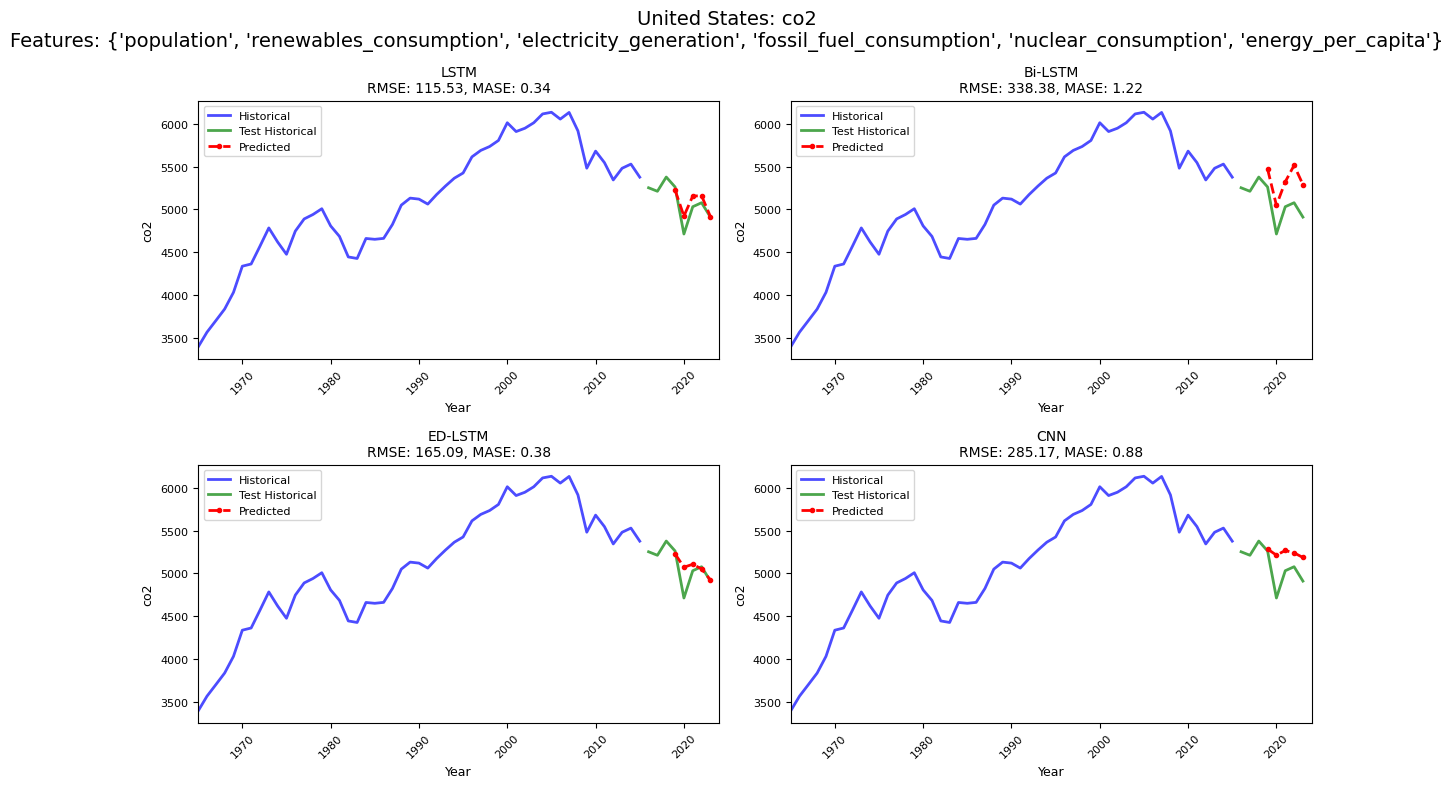

In [18]:
plot_multi_models('United States', 'co2')

Loaded predictions for gdp


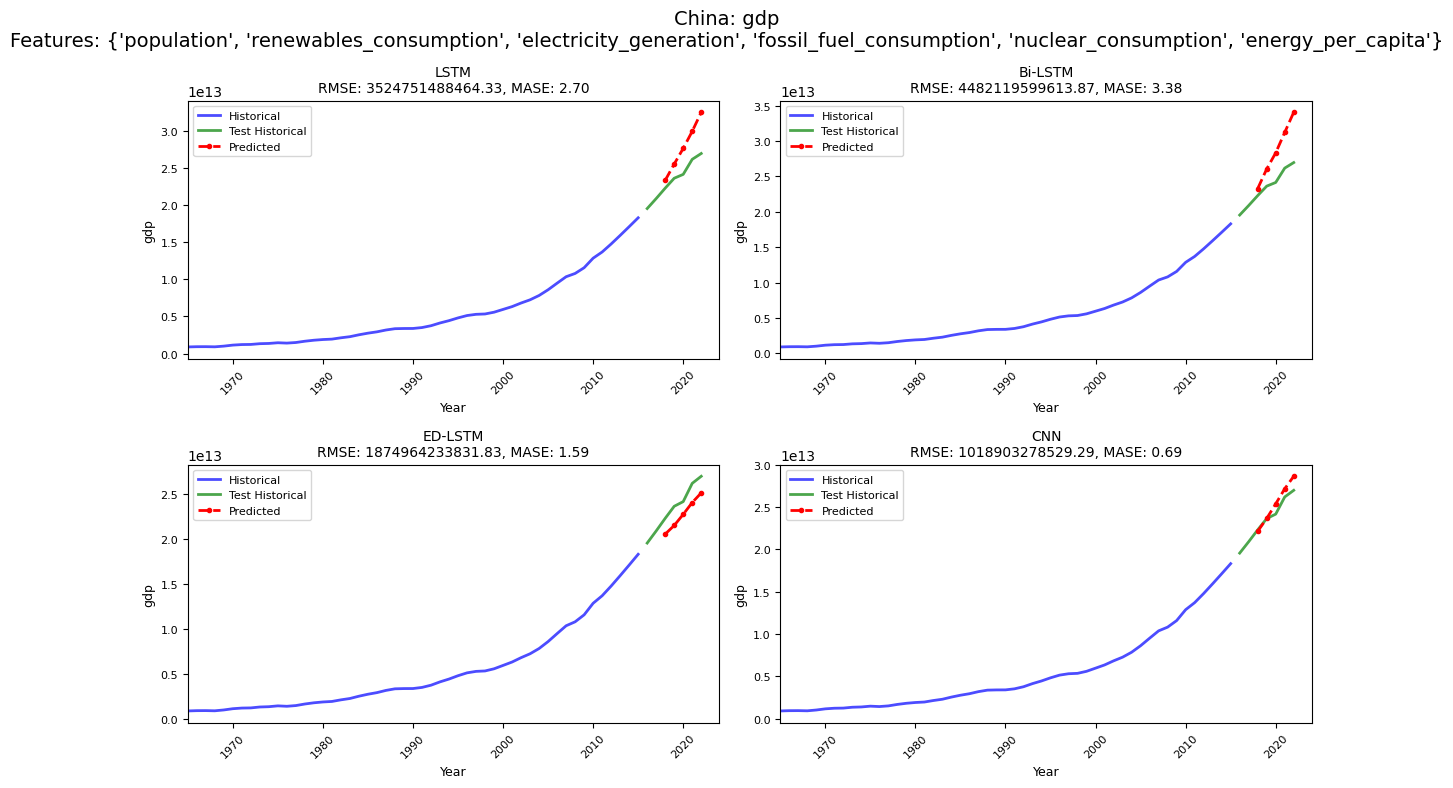

In [19]:
plot_multi_models('China', 'gdp')

Loaded predictions for primary_energy_consumption


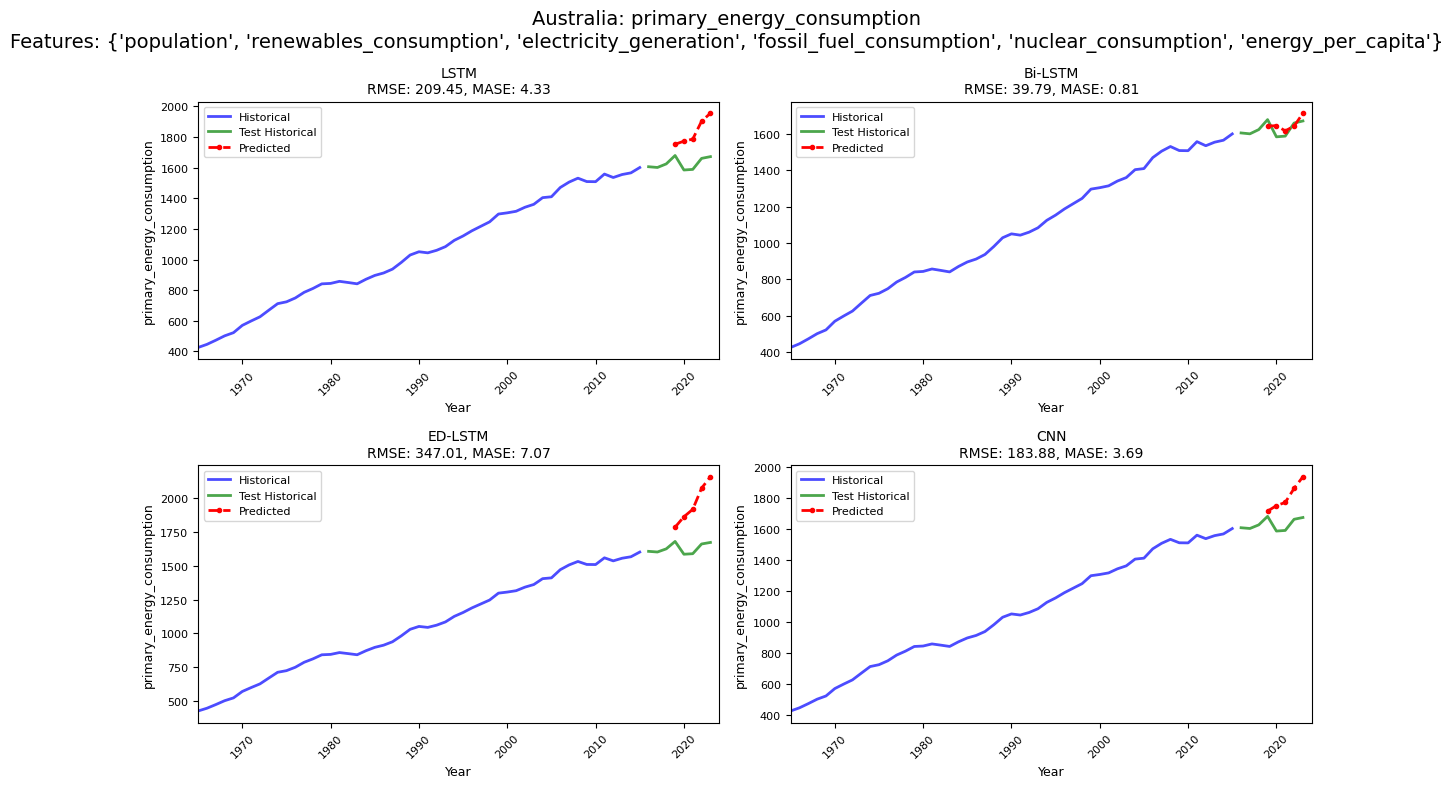

In [20]:
plot_multi_models('Australia', 'primary_energy_consumption')